# Part-of-speech Tagging Using RNNs

Based on the code in the book [Deep Learning for Natural Language Processing: A Gentle Introduction](https://github.com/clulab/gentlenlp/tree/main)

This notebook implements a part-of-speech tagger for Spanish using recurrent neural networks. Part-of-speech determines the grammatical category of every word in a sequence

Some initialization:

In [1]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cpu
random seed: 1234


### Load the dataset

We will use the Spanish AnCora dataset that is included in the Universal Dependencies version 2.8 dataset. 

The words and their POS tags will be in  CoNLLUP format. We need to install the `conllu` package

In [ ]:
!pip install conllu

Defaulting to user installation because normal site-packages is not writeable


Function to read the words and the tags of all the sentences in the dataset

In [2]:
from conllu import parse_incr

def read_tags(filename):
    data = {'words': [], 'tags': []}
    with open(filename) as f:
        for sent in parse_incr(f):
            words = [tok['form'] for tok in sent]
            tags = [tok['upos'] for tok in sent]
            data['words'].append(words)
            data['tags'].append(tags)
    return pd.DataFrame(data)

Let's have a look at the sequences of words and corresponding tags in the train set

In [3]:
train_df = read_tags('es_ancora-ud-train.conllup')
train_df

,words,tags
0,"[Las, reservas, de, oro, y, divisas, de, Rusia...","[DET, NOUN, ADP, NOUN, CCONJ, NOUN, ADP, PROPN..."
1,"[Según, el, informe, ,, el, 19, de, mayo, las,...","[ADP, DET, NOUN, PUNCT, DET, NUM, ADP, NOUN, D..."
2,"[Los, activos, en, divisas, en, poder, del, de...","[DET, NOUN, ADP, NOUN, ADP, NOUN, _, ADP, DET,..."
3,"[Las, reservas, en, oro, se, valoran, en, base...","[DET, NOUN, ADP, NOUN, PRON, VERB, ADP, NOUN, ..."
4,"[El, presidente, de, la, Generalitat, ,, Jordi...","[DET, NOUN, ADP, DET, PROPN, PUNCT, PROPN, PRO..."
...,...,...
14282,"["", Si, eso, se, considera, plagio, ,, yo, te,...","[PUNCT, SCONJ, PRON, PRON, VERB, NOUN, PUNCT, ..."
14283,"[Y, es, que, las, cosas, más, originales, suel...","[CCONJ, AUX, SCONJ, DET, NOUN, ADV, ADJ, VERB,..."
14284,"["", Sólo, me, faltaba, el, principio, ,, enton...","[PUNCT, ADV, PRON, VERB, DET, NOUN, PUNCT, ADV..."
14285,"["", Y, ,, ya, en, el, estudio, ,, _, metí, un,...","[PUNCT, CCONJ, PUNCT, ADV, ADP, DET, NOUN, PUN..."


Preprocessing: lower case all words, and replace all numbers with '0':

In [4]:
def preprocess(words):
    result = []
    for w in words:
        w = w.lower()
        if w.isdecimal():
            w = '0'
        result.append(w)
    return result

train_df['words'] = train_df['words'].progress_map(preprocess)
train_df

  0%|          | 0/14287 [00:00<?, ?it/s]

,words,tags
0,"[las, reservas, de, oro, y, divisas, de, rusia...","[DET, NOUN, ADP, NOUN, CCONJ, NOUN, ADP, PROPN..."
1,"[según, el, informe, ,, el, 0, de, mayo, las, ...","[ADP, DET, NOUN, PUNCT, DET, NUM, ADP, NOUN, D..."
2,"[los, activos, en, divisas, en, poder, del, de...","[DET, NOUN, ADP, NOUN, ADP, NOUN, _, ADP, DET,..."
3,"[las, reservas, en, oro, se, valoran, en, base...","[DET, NOUN, ADP, NOUN, PRON, VERB, ADP, NOUN, ..."
4,"[el, presidente, de, la, generalitat, ,, jordi...","[DET, NOUN, ADP, DET, PROPN, PUNCT, PROPN, PRO..."
...,...,...
14282,"["", si, eso, se, considera, plagio, ,, yo, te,...","[PUNCT, SCONJ, PRON, PRON, VERB, NOUN, PUNCT, ..."
14283,"[y, es, que, las, cosas, más, originales, suel...","[CCONJ, AUX, SCONJ, DET, NOUN, ADV, ADJ, VERB,..."
14284,"["", sólo, me, faltaba, el, principio, ,, enton...","[PUNCT, ADV, PRON, VERB, DET, NOUN, PUNCT, ADV..."
14285,"["", y, ,, ya, en, el, estudio, ,, _, metí, un,...","[PUNCT, CCONJ, PUNCT, ADV, ADP, DET, NOUN, PUN..."


### Prepare the dataset for training

We load the GloVe embeddings for Spanish, which include a representation for the unknown token.

[GloVe embeddings](https://nlp.stanford.edu/data/glove.6B.zip) can be downloaded from the [Stanford GloVe website](https://nlp.stanford.edu/projects/glove/). Once the `glove.6B.zip` file is downloaded, uncompress it and place the extracted `glove.6B.300d.txt' file in the notebook folder.

In [5]:
from gensim.models import KeyedVectors
glove = KeyedVectors.load_word2vec_format('glove-sbwc.i25.vec')
glove.vectors.shape

(855380, 300)

In [6]:
# these embeddings already include <unk>
unk_tok = '<unk>'
unk_id = glove.key_to_index[unk_tok]
unk_tok, unk_id

('<unk>', 855379)

We add a new token for padding

In [7]:
# add padding embedding
pad_tok = '<pad>'
pad_emb = np.zeros(300)
glove.add_vector(pad_tok, pad_emb)
pad_tok_id = glove.key_to_index[pad_tok]
pad_tok, pad_tok_id

c:\ProgramData\anaconda3\Lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


('<pad>', 855380)

Next, construct actual PyTorch `Dataset` and `DataLoader` objects for the train/dev/test partitions. We convert all words to their corresponding index for the Glove embedding.

In [8]:
def get_ids(tokens, key_to_index, unk_id=None):
    return [key_to_index.get(tok, unk_id) for tok in tokens]

def get_word_ids(tokens):
    return get_ids(tokens, glove.key_to_index, unk_id)

# add new column to the dataframe
train_df['word ids'] = train_df['words'].progress_map(get_word_ids)
train_df

  0%|          | 0/14287 [00:00<?, ?it/s]

,words,tags,word ids
0,"[las, reservas, de, oro, y, divisas, de, rusia...","[DET, NOUN, ADP, NOUN, CCONJ, NOUN, ADP, PROPN...","[10, 2053, 0, 1046, 4, 7542, 0, 936, 11138, 6,..."
1,"[según, el, informe, ,, el, 0, de, mayo, las, ...","[ADP, DET, NOUN, PUNCT, DET, NUM, ADP, NOUN, D...","[79, 2, 102, 855379, 2, 6, 0, 278, 10, 2053, 0..."
2,"[los, activos, en, divisas, en, poder, del, de...","[DET, NOUN, ADP, NOUN, ADP, NOUN, _, ADP, DET,...","[8, 2100, 3, 7542, 3, 238, 9, 0, 2, 730, 408, ..."
3,"[las, reservas, en, oro, se, valoran, en, base...","[DET, NOUN, ADP, NOUN, PRON, VERB, ADP, NOUN, ...","[10, 2053, 3, 1046, 11, 23709, 3, 261, 7, 6, 2..."
4,"[el, presidente, de, la, generalitat, ,, jordi...","[DET, NOUN, ADP, DET, PROPN, PUNCT, PROPN, PRO...","[2, 74, 0, 1, 3367, 855379, 4653, 6071, 855379..."
...,...,...,...
14282,"["", si, eso, se, considera, plagio, ,, yo, te,...","[PUNCT, SCONJ, PRON, PRON, VERB, NOUN, PUNCT, ...","[855379, 42, 313, 11, 749, 22048, 855379, 432,..."
14283,"[y, es, que, las, cosas, más, originales, suel...","[CCONJ, AUX, SCONJ, DET, NOUN, ADV, ADJ, VERB,...","[4, 20, 5, 10, 543, 22, 3803, 2591, 413, 74121..."
14284,"["", sólo, me, faltaba, el, principio, ,, enton...","[PUNCT, ADV, PRON, VERB, DET, NOUN, PUNCT, ADV...","[855379, 109, 141, 13242, 2, 568, 855379, 304,..."
14285,"["", y, ,, ya, en, el, estudio, ,, _, metí, un,...","[PUNCT, CCONJ, PUNCT, ADV, ADP, DET, NOUN, PUN...","[855379, 4, 855379, 47, 3, 2, 478, 855379, 855..."


We get a class index for every possible tag

In [9]:
pad_tag = '<pad>'
index_to_tag = train_df['tags'].explode().unique().tolist() + [pad_tag]
tag_to_index = {t:i for i,t in enumerate(index_to_tag)}
pad_tag_id = tag_to_index[pad_tag]
pad_tag, pad_tag_id

('<pad>', 18)

In [10]:
index_to_tag

['DET',
 'NOUN',
 'ADP',
 'CCONJ',
 'PROPN',
 'VERB',
 'NUM',
 'PUNCT',
 'ADV',
 '_',
 'AUX',
 'PRON',
 'ADJ',
 'SCONJ',
 'PART',
 'SYM',
 'INTJ',
 'X',
 '<pad>']

We get the class index of all the tags in a sentence

In [11]:
def get_tag_ids(tags):
    return get_ids(tags, tag_to_index)

train_df['tag ids'] = train_df['tags'].progress_map(get_tag_ids)
train_df

  0%|          | 0/14287 [00:00<?, ?it/s]

,words,tags,word ids,tag ids
0,"[las, reservas, de, oro, y, divisas, de, rusia...","[DET, NOUN, ADP, NOUN, CCONJ, NOUN, ADP, PROPN...","[10, 2053, 0, 1046, 4, 7542, 0, 936, 11138, 6,...","[0, 1, 2, 1, 3, 1, 2, 4, 5, 6, 1, 2, 1, 3, 0, ..."
1,"[según, el, informe, ,, el, 0, de, mayo, las, ...","[ADP, DET, NOUN, PUNCT, DET, NUM, ADP, NOUN, D...","[79, 2, 102, 855379, 2, 6, 0, 278, 10, 2053, 0...","[2, 0, 1, 7, 0, 6, 2, 1, 0, 1, 2, 1, 3, 1, 9, ..."
2,"[los, activos, en, divisas, en, poder, del, de...","[DET, NOUN, ADP, NOUN, ADP, NOUN, _, ADP, DET,...","[8, 2100, 3, 7542, 3, 238, 9, 0, 2, 730, 408, ...","[0, 1, 2, 1, 2, 1, 9, 2, 0, 4, 4, 3, 0, 4, 2, ..."
3,"[las, reservas, en, oro, se, valoran, en, base...","[DET, NOUN, ADP, NOUN, PRON, VERB, ADP, NOUN, ...","[10, 2053, 3, 1046, 11, 23709, 3, 261, 7, 6, 2...","[0, 1, 2, 1, 11, 5, 2, 1, 2, 6, 1, 12, 2, 0, 1..."
4,"[el, presidente, de, la, generalitat, ,, jordi...","[DET, NOUN, ADP, DET, PROPN, PUNCT, PROPN, PRO...","[2, 74, 0, 1, 3367, 855379, 4653, 6071, 855379...","[0, 1, 2, 0, 4, 7, 4, 4, 7, 5, 12, 13, 0, 4, 5..."
...,...,...,...,...
14282,"["", si, eso, se, considera, plagio, ,, yo, te,...","[PUNCT, SCONJ, PRON, PRON, VERB, NOUN, PUNCT, ...","[855379, 42, 313, 11, 749, 22048, 855379, 432,...","[7, 13, 11, 11, 5, 1, 7, 11, 11, 5, 0, 11, 11,..."
14283,"[y, es, que, las, cosas, más, originales, suel...","[CCONJ, AUX, SCONJ, DET, NOUN, ADV, ADJ, VERB,...","[4, 20, 5, 10, 543, 22, 3803, 2591, 413, 74121...","[3, 10, 13, 0, 1, 8, 12, 5, 10, 12, 2, 1, 7]"
14284,"["", sólo, me, faltaba, el, principio, ,, enton...","[PUNCT, ADV, PRON, VERB, DET, NOUN, PUNCT, ADV...","[855379, 109, 141, 13242, 2, 568, 855379, 304,...","[7, 8, 11, 5, 0, 1, 7, 8, 7, 11, 5, 0, 1, 3, 1..."
14285,"["", y, ,, ya, en, el, estudio, ,, _, metí, un,...","[PUNCT, CCONJ, PUNCT, ADV, ADP, DET, NOUN, PUN...","[855379, 4, 855379, 47, 3, 2, 478, 855379, 855...","[7, 3, 7, 8, 2, 0, 1, 7, 11, 5, 0, 1, 2, 1, 12..."


We repeat the same process for the validation set

In [12]:
dev_df = read_tags('es_ancora-ud-dev.conllup')
dev_df['words'] = dev_df['words'].progress_map(preprocess)
dev_df['word ids'] = dev_df['words'].progress_map(lambda x: get_ids(x, glove.key_to_index, unk_id))
dev_df['tag ids'] = dev_df['tags'].progress_map(lambda x: get_ids(x, tag_to_index))
dev_df

  0%|          | 0/1654 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

,words,tags,word ids,tag ids
0,"[el, gobernante, ,, con, ganada, fama, desde, ...","[DET, NOUN, PUNCT, ADP, ADJ, NOUN, ADP, SCONJ,...","[2, 6221, 855379, 14, 18832, 3449, 41, 5, 626,...","[0, 1, 7, 2, 12, 1, 2, 13, 5, 5, 6, 1, 9, 2, 0..."
1,"[chávez, se, despidió, del, de, el, mundanal, ...","[PROPN, PRON, VERB, _, ADP, DET, ADJ, NOUN, DE...","[3063, 11, 14578, 9, 0, 2, 115792, 5407, 2, 21...","[4, 11, 5, 9, 2, 0, 12, 1, 0, 1, 1, 2, 0, 8, 1..."
2,"[desde, entonces, entró, en, silencio, absolut...","[ADP, ADV, VERB, ADP, NOUN, ADJ, PUNCT]","[41, 304, 2127, 3, 3323, 4133, 855379]","[2, 8, 5, 2, 1, 12, 7]"
3,"[nadie, sabe, cuál, es, la, nueva, fecha, que,...","[PRON, VERB, PRON, AUX, DET, ADJ, NOUN, PRON, ...","[1113, 1428, 2639, 20, 1, 122, 364, 5, 2022, 1...","[11, 5, 11, 10, 0, 12, 1, 11, 5, 2, 0, 1, 7, 3..."
4,"[por, su, boca, suelen, hablar, de, vez, en, c...","[ADP, DET, NOUN, VERB, VERB, ADP, NOUN, ADP, A...","[12, 17, 2779, 2591, 1489, 0, 90, 3, 51, 110, ...","[2, 0, 1, 5, 5, 2, 1, 2, 8, 8, 0, 1, 2, 4, 4, ..."
...,...,...,...,...
1649,"[el, líder, peneuvista, lee, un, artículo, de,...","[DET, NOUN, ADJ, VERB, DET, NOUN, ADP, PROPN, ...","[2, 943, 52550, 3860, 13, 68, 0, 3982, 855379,...","[0, 1, 12, 5, 0, 1, 2, 4, 7, 12, 9, 2, 0, 1, 7..."
1650,"[arzalluz, recuperó, ayer, la, hemeroteca, par...","[PROPN, VERB, ADV, DET, NOUN, ADP, PUNCT, VERB...","[20919, 8012, 209, 1, 39731, 15, 855379, 29599...","[4, 5, 8, 0, 1, 2, 7, 5, 7, 2, 4, 2, 7, 1, 9, ..."
1651,"[_, citó, un, texto, del, de, el, presidente, ...","[PRON, VERB, DET, NOUN, _, ADP, DET, NOUN, ADP...","[855379, 9778, 13, 682, 9, 0, 2, 74, 3, 2, 980...","[11, 5, 0, 1, 9, 2, 0, 1, 2, 0, 1, 4, 4, 9, 2,..."
1652,"[el, artículo, explicaba, :, "", vientos, de, r...","[DET, NOUN, VERB, PUNCT, PUNCT, NOUN, ADP, NOU...","[2, 68, 13216, 855379, 855379, 4348, 0, 15123,...","[0, 1, 5, 7, 7, 1, 2, 1, 10, 0, 11, 5, 5, 11, ..."


Create the Dataset for the Dataloader

In [13]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        x = torch.tensor(self.x[index])
        y = torch.tensor(self.y[index])
        return x, y

`collate_fn` will be used by `DataLoader` to pad all sentences in the same batch to the same length.

In [14]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # separate xs and ys
    xs, ys = zip(*batch)
    # get lengths
    lengths = [len(x) for x in xs]
    # pad sequences
    x_padded = pad_sequence(xs, batch_first=True, padding_value=pad_tok_id)
    y_padded = pad_sequence(ys, batch_first=True, padding_value=pad_tag_id)
    # return padded
    return x_padded, y_padded, lengths

### Definition of the model

Now construct our PyTorch model:

In [ ]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class MyModel(nn.Module):
    def __init__(self, vectors, hidden_size, num_layers, bidirectional, dropout, output_size):
        super().__init__()
        # ensure vectors is a tensor
        if not torch.is_tensor(vectors):
            vectors = torch.tensor(vectors)
        # init embedding layer with pretrained vectors
        self.embedding = nn.Embedding.from_pretrained(embeddings=vectors)
        # lstm layer
        self.lstm = nn.LSTM(
            input_size=vectors.shape[1],
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True)
        # init dropout
        self.dropout = nn.Dropout(dropout)
        # final classifier layer
        self.classifier = nn.Linear(
            in_features=hidden_size * 2 if bidirectional else hidden_size,
            out_features=output_size)
        
    def forward(self, x_padded, x_lengths):
        # get embeddings
        output = self.embedding(x_padded)
        output = self.dropout(output)
        # pack data before lstm
        packed = pack_padded_sequence(output, x_lengths, batch_first=True, enforce_sorted=False)
        packed, _ = self.lstm(packed)
        # unpack data before rest of model
        output, _ = pad_packed_sequence(packed, batch_first=True)
        output = self.dropout(output)
        output = self.classifier(output)
        return output

We instantiate the model

In [16]:
from torch import optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# hyperparameters
lr = 1e-3
weight_decay = 1e-5
batch_size = 100
shuffle = True
n_epochs = 10
vectors = glove.vectors
hidden_size = 100
num_layers = 2
bidirectional = True
dropout = 0.1
output_size = len(index_to_tag)

# initialize the model, loss function, optimizer, and data-loader
model = MyModel(vectors, hidden_size, num_layers, bidirectional, dropout, output_size).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
train_ds = MyDataset(train_df['word ids'], train_df['tag ids'])
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
dev_ds = MyDataset(dev_df['word ids'], dev_df['tag ids'])
dev_dl = DataLoader(dev_ds, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

train_loss, train_acc = [], []
dev_loss, dev_acc = [], []

### Training

We are now ready to train!

In [ ]:
# train the model
for epoch in range(n_epochs):
    losses, acc = [], []
    model.train()
    for x_padded, y_padded, lengths in tqdm(train_dl, desc=f'epoch {epoch+1} (train)'):
        # clear gradients
        model.zero_grad()
        # send batch to right device
        x_padded = x_padded.to(device)
        y_padded = y_padded.to(device)
        # predict label scores
        y_pred = model(x_padded, lengths)
        # reshape output
        y_true = torch.flatten(y_padded)
        y_pred = y_pred.view(-1, output_size)
        # create mask to ignore padding tokens in loss and metrics
        mask = y_true != pad_tag_id
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        # compute loss
        loss = loss_func(y_pred, y_true)
        # accumulate for plotting
        gold = y_true.detach().cpu().numpy()
        pred = np.argmax(y_pred.detach().cpu().numpy(), axis=1)
        losses.append(loss.detach().cpu().item())
        acc.append(accuracy_score(gold, pred))
        # backpropagate
        loss.backward()
        # optimize model parameters
        optimizer.step()
    train_loss.append(np.mean(losses))
    train_acc.append(np.mean(acc))
    
    model.eval()
    with torch.no_grad():
        losses, acc = [], []
        for x_padded, y_padded, lengths in tqdm(dev_dl, desc=f'epoch {epoch+1} (dev)'):
            x_padded = x_padded.to(device)
            y_padded = y_padded.to(device)
            y_pred = model(x_padded, lengths)
            y_true = torch.flatten(y_padded)
            y_pred = y_pred.view(-1, output_size)
            mask = y_true != pad_tag_id
            y_true = y_true[mask]
            y_pred = y_pred[mask]
            loss = loss_func(y_pred, y_true)
            gold = y_true.cpu().numpy()
            pred = np.argmax(y_pred.cpu().numpy(), axis=1)
            losses.append(loss.cpu().item())
            acc.append(accuracy_score(gold, pred))
        dev_loss.append(np.mean(losses))
        dev_acc.append(np.mean(acc))

epoch 1 (train):   0%|          | 0/143 [00:00<?, ?it/s]

output torch.Size([100, 73, 300])
packed torch.Size([3226, 300])
y_padded shape: torch.Size([100, 73])
y_true shape: torch.Size([7300])
y_pred shape: torch.Size([100, 73, 19])
y_pred reshaped shape: torch.Size([7300, 19])
output torch.Size([100, 74, 300])
packed torch.Size([3459, 300])
y_padded shape: torch.Size([100, 74])
y_true shape: torch.Size([7400])
y_pred shape: torch.Size([100, 74, 19])
y_pred reshaped shape: torch.Size([7400, 19])
output torch.Size([100, 81, 300])
packed torch.Size([3282, 300])
y_padded shape: torch.Size([100, 81])
y_true shape: torch.Size([8100])
y_pred shape: torch.Size([100, 81, 19])
y_pred reshaped shape: torch.Size([8100, 19])
output torch.Size([100, 83, 300])
packed torch.Size([3329, 300])
y_padded shape: torch.Size([100, 83])
y_true shape: torch.Size([8300])
y_pred shape: torch.Size([100, 83, 19])
y_pred reshaped shape: torch.Size([8300, 19])
output torch.Size([100, 85, 300])
packed torch.Size([3124, 300])
y_padded shape: torch.Size([100, 85])
y_true sh

KeyboardInterrupt: 

Plot loss and accuracy on dev after each epoch:

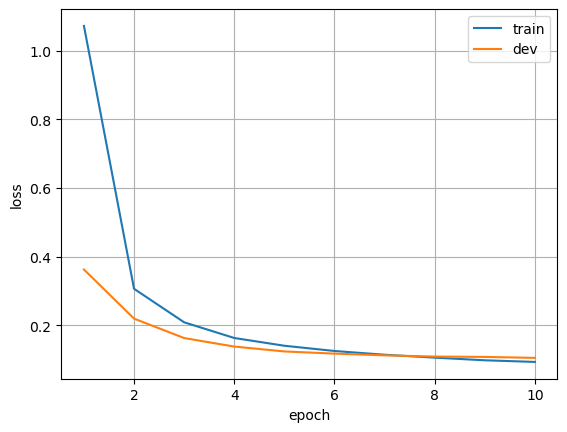

In [19]:
import matplotlib.pyplot as plt

x = np.arange(n_epochs) + 1

plt.plot(x, train_loss)
plt.plot(x, dev_loss)
plt.legend(['train', 'dev'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)

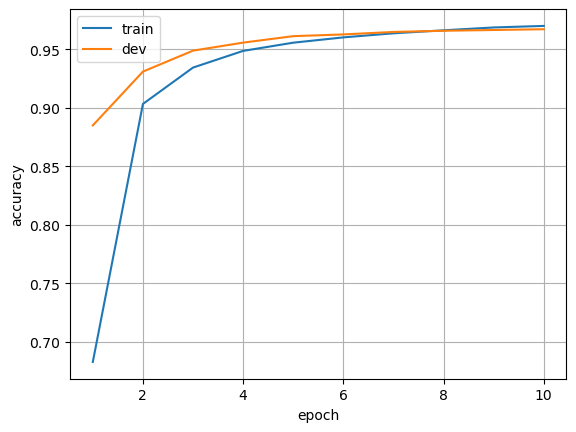

In [20]:
plt.plot(x, train_acc)
plt.plot(x, dev_acc)
plt.legend(['train', 'dev'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)

### Evaluation on the test set

In [21]:
test_df = read_tags('es_ancora-ud-test.conllup')
test_df['words'] = test_df['words'].progress_map(preprocess)
test_df['word ids'] = test_df['words'].progress_map(lambda x: get_ids(x, glove.key_to_index, unk_id))
test_df['tag ids'] = test_df['tags'].progress_map(lambda x: get_ids(x, tag_to_index))
test_df

  0%|          | 0/1721 [00:00<?, ?it/s]

  0%|          | 0/1721 [00:00<?, ?it/s]

  0%|          | 0/1721 [00:00<?, ?it/s]

,words,tags,word ids,tag ids
0,"[partidario, de, la, "", perestroika, "", de, mi...","[ADJ, ADP, DET, PUNCT, NOUN, PUNCT, ADP, PROPN...","[8983, 0, 1, 855379, 54911, 855379, 0, 41295, ...","[12, 2, 0, 7, 1, 7, 2, 4, 4, 2, 0, 4, 4, 7, 2,..."
1,"[días, después, ,, el, 0, de, noviembre, de, 0...","[NOUN, ADV, PUNCT, DET, NUM, ADP, NOUN, ADP, N...","[204, 78, 855379, 2, 6, 0, 330, 0, 6, 855379, ...","[1, 8, 7, 0, 6, 2, 1, 2, 6, 7, 5, 12, 2, 0, 1,..."
2,"[después, del, de, el, triunfo, electoral, de,...","[ADV, _, ADP, DET, NOUN, ADJ, ADP, DET, NOUN, ...","[78, 9, 0, 2, 2150, 922, 0, 8, 2879, 855379, 4...","[8, 9, 2, 0, 1, 12, 2, 0, 1, 7, 12, 1, 7, 2, 0..."
3,"[descontento, por, la, falta, de, apoyo, del, ...","[ADJ, ADP, DET, NOUN, ADP, NOUN, _, ADP, DET, ...","[10482, 12, 1, 435, 0, 167, 9, 0, 2, 168, 1671...","[12, 2, 0, 1, 2, 1, 9, 2, 0, 4, 4, 4, 7, 4, 7,..."
4,"[el, ministerio, chino, de, asuntos, exteriore...","[DET, PROPN, ADJ, ADP, PROPN, PROPN, VERB, ADV...","[2, 481, 2863, 0, 498, 1374, 5789, 170, 2, 531...","[0, 4, 12, 2, 4, 4, 5, 8, 0, 1, 2, 0, 1, 12, 1..."
...,...,...,...,...
1716,"[esto, representa, la, rescisión, del, de, el,...","[PRON, VERB, DET, NOUN, _, ADP, DET, NOUN, ADP...","[186, 1206, 1, 18091, 9, 0, 2, 1097, 0, 4191, ...","[11, 5, 0, 1, 9, 2, 0, 1, 2, 1, 2, 0, 1, 2, 4,..."
1717,"[radio, liberty, empezó, a, emitir, en, 0, com...","[PROPN, PROPN, VERB, ADP, VERB, ADP, NOUN, SCO...","[1040, 17913, 1754, 7, 5609, 3, 6, 21, 1463, 0...","[4, 4, 5, 2, 5, 2, 1, 13, 1, 2, 1, 12, 2, 4, 4..."
1718,"[la, emisora, dejó, de, emitir, el, 0, de, may...","[DET, NOUN, VERB, ADP, VERB, DET, NUM, ADP, NO...","[1, 7111, 1176, 0, 5609, 2, 6, 0, 278, 9, 0, 2...","[0, 1, 5, 2, 5, 0, 6, 2, 1, 9, 2, 0, 1, 12, 7]"
1719,"[la, idea, de, rne, es, ceder, los, terrenos, ...","[DET, NOUN, ADP, PROPN, AUX, VERB, DET, NOUN, ...","[1, 1003, 0, 29150, 20, 8758, 8, 3405, 18, 7, ...","[0, 1, 2, 4, 10, 5, 0, 1, 9, 2, 0, 4, 9, 2, 0,..."


Now let's evaluate on the test partition:

In [22]:
from sklearn.metrics import classification_report

model.eval()

test_ds = MyDataset(test_df['word ids'], test_df['tag ids'])
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

all_y_true = []
all_y_pred = []

with torch.no_grad():
    for x_padded, y_padded, lengths in tqdm(test_dl):
        x_padded = x_padded.to(device)
        y_pred = model(x_padded, lengths)
        y_true = torch.flatten(y_padded)
        y_pred = y_pred.view(-1, output_size)
        mask = y_true != pad_tag_id
        y_true = y_true[mask]
        y_pred = torch.argmax(y_pred[mask], dim=1)
        all_y_true.append(y_true.cpu().numpy())
        all_y_pred.append(y_pred.cpu().numpy())

y_true = np.concatenate(all_y_true)
y_pred = np.concatenate(all_y_pred)
target_names = index_to_tag[:-2]
print(classification_report(y_true, y_pred, target_names=target_names))

  0%|          | 0/18 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         DET       0.99      1.00      0.99      8055
        NOUN       0.95      0.96      0.95      9531
         ADP       1.00      1.00      1.00      8332
       CCONJ       0.99      1.00      0.99      1439
       PROPN       0.93      0.89      0.90      4094
        VERB       0.98      0.98      0.98      4636
         NUM       0.95      0.88      0.92       977
       PUNCT       0.95      0.99      0.97      6334
         ADV       0.97      0.96      0.97      1763
           _       1.00      1.00      1.00      1166
         AUX       0.98      0.98      0.98      1304
        PRON       0.96      0.93      0.94      3250
         ADJ       0.92      0.92      0.92      3468
       SCONJ       0.94      0.98      0.96      1210
        PART       0.85      0.61      0.71        18
         SYM       0.88      0.54      0.67        28
        INTJ       0.78      0.44      0.56        16

    accuracy              

Let's generate a confusion matrix for all POS tags in the data:

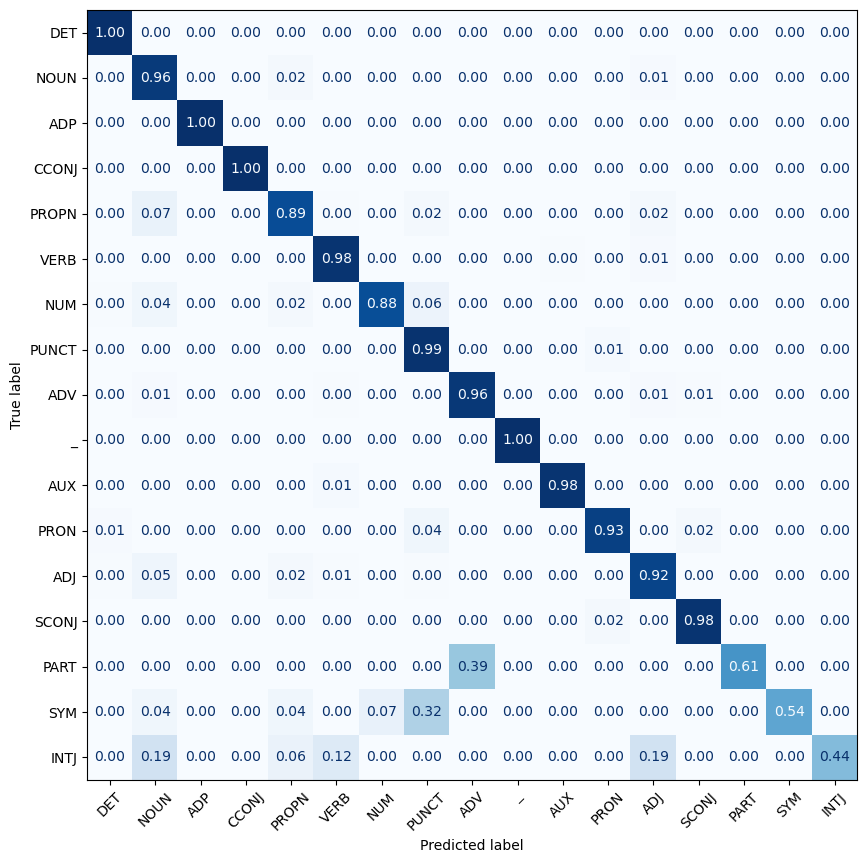

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=target_names,
)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(
    cmap='Blues',
    values_format='.2f',
    colorbar=False,
    ax=ax,
    xticks_rotation=45,
)